In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define the Physics-Informed Neural Network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Define the neural network structure: 3 fully connected layers with tanh activation
        self.net = nn.Sequential(
            nn.Linear(1, 20),   # Input layer: 1 node (independent variable x), hidden layer with 20 nodes
            nn.Tanh(),
            nn.Linear(20, 20),  # Hidden layer with 20 nodes
            nn.Tanh(),
            nn.Linear(20, 1)    # Output layer: 1 node (dependent variable y)
        )
    
    def forward(self, x):
        return self.net(x)

# Define the differential equation: dy/dx + y = 0, with initial condition y(0)=1 (analytical solution: y = e^(-x))
def compute_loss(model):
    # Initial condition loss (x=0, y=1)
    x_ic = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
    y_ic_true = torch.tensor([[1.0]], dtype=torch.float32)
    y_ic_pred = model(x_ic)
    loss_ic = torch.mean((y_ic_pred - y_ic_true)**2)  # MSE loss
    
    # Differential equation residual loss (sample points in the domain)
    x_collocation = torch.linspace(0, 10, 10000).view(-1, 1).requires_grad_(True)
    y_pred = model(x_collocation)
    
    # Compute dy/dx (using automatic differentiation)
    dydx = torch.autograd.grad(
        outputs=y_pred,
        inputs=x_collocation,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True
    )[0]
    
    # Differential equation residual: dy/dx + y = 0
    equation_residual = dydx + y_pred
    loss_ode = torch.mean(equation_residual**2)  # MSE loss
    
    # Total loss = initial condition loss + ODE residual loss
    total_loss = loss_ic + loss_ode
    return total_loss

# Training configuration
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer
epochs = 10000  # Number of training epochs

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = compute_loss(model)
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:  # Print loss every 1000 epochs
        print(f'Epoch {epoch}, Loss: {loss.item()}')


# Model prediction and visualization
x_test = torch.linspace(0, 10, 10000).view(-1, 1)
y_pred = model(x_test).detach().numpy()
y_true = np.exp(-x_test.numpy())  # Analytical solution

Epoch 0, Loss: 0.9832956194877625
Epoch 1000, Loss: 5.4837437346577644e-06
Epoch 2000, Loss: 7.760135076750885e-07
Epoch 3000, Loss: 4.3969342300442804e-07
Epoch 4000, Loss: 4.410149188061041e-07
Epoch 5000, Loss: 0.0005256475997157395
Epoch 6000, Loss: 3.6028362160323013e-07
Epoch 7000, Loss: 5.688784199264774e-07
Epoch 8000, Loss: 1.9977461818143638e-07
Epoch 9000, Loss: 9.704699550638907e-07


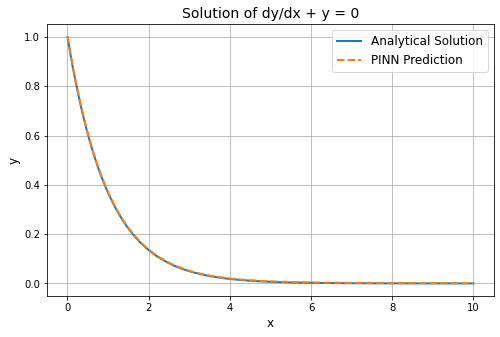

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
plt.figure(figsize=(8, 5))
plt.plot(x_test.numpy(), y_true, label='Analytical Solution', linewidth=2)
plt.plot(x_test.numpy(), y_pred, '--', label='PINN Prediction', linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Solution of dy/dx + y = 0', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_true = y_true.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_true
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.9998914420975993, mae_pinn: 0.002032418502494693, rmse_pinn: 0.0020891057793051004, inf_norm_pinn: 0.0032586753368377686


In [4]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': x_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

data_to_save.to_csv('pinn_02.csv', index=False)
print("pinn_02.csv")

数据已保存至 pinn_02.csv
